In [2]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = "1"

from keras import backend as K
from keras.layers import Input, Dense, merge, Flatten, Dropout, Lambda
from keras.layers import BatchNormalization, Merge, Activation, GlobalAveragePooling2D
from keras.layers import Multiply, Add
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import imgaug as ia
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import numpy as np
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical

def get_data(add_noise):
    """
    add_noise: add gaussian noise to both training and testing images
    --> We want to know if attention is helpful or not
    """
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    # Confirm the dimension
    if len(X_train.shape) == 3:
        # in gray-scale
        X_train = np.expand_dims(X_train, axis = -1)
        X_test = np.expand_dims(X_test, axis = -1)
        
    if add_noise:
        aug_seq = iaa.Sequential([iaa.AdditiveGaussianNoise(scale=0.2 * 255)])
        X_train = aug_seq.augment_images(X_train)
        X_test = aug_seq.augment_images(X_test)
        
    X_train = X_train / 255.
    X_test = X_test / 255.
    
    return X_train, X_test, y_train, y_test

In [4]:
def build_model(attention):

    inputs = Input(shape= X_train.shape[1:],
                   name='input')

    conv_1a = Convolution2D(filters=64, 
                            kernel_size=(3, 3),
                            padding = 'same',
                            name='conv_1')(inputs)
    conv_1a = BatchNormalization(axis = -1)(conv_1a)
    conv_1a = Activation('relu')(conv_1a)
    conv_1a = MaxPooling2D(pool_size=(2,2), padding='same')(conv_1a)

    conv_2a = Convolution2D(filters = 128, 
                            kernel_size=(3,3),
                            padding = 'same',
                            name='conv_2')(conv_1a)
    conv_2a = BatchNormalization(axis = -1)(conv_2a)
    conv_2a = Activation('relu')(conv_2a)
    #conv_2a = MaxPooling2D(pool_size=(2,2))(conv_2a)

    if attention:
        # Create a pixel weighted layer
        ## To make the attention focus on the spot, should i add total-variation loss on att_ ?
        att_ = Convolution2D(filters=1, kernel_size=(1,1), padding='same', activation='sigmoid')(conv_2a) # tanh or sigmoid?
        att_ = Multiply()([conv_2a, att_])
    else:
        att_ = Lambda(lambda x: x * 1)(conv_2a) # make conv_2a multiply with ones...
        att_ = Multiply()([conv_2a, att_])

    conv_2a = MaxPooling2D(pool_size=(2,2))(att_)

    conv_3a = Convolution2D(filters=256, 
                            kernel_size=(3,3), 
                            padding='same')(conv_2a)
    conv_3a = BatchNormalization(axis = -1)(conv_3a)
    conv_3a = Activation('relu')(conv_3a)

    gap = GlobalAveragePooling2D()(conv_3a)
    out = Dense(10, activation='softmax')(gap)

    model = Model(inputs=inputs, outputs=out)
    return model


In [9]:
# w/o noise, w/o attention
# w/o noise, w attention
# w noise, w/o attention
# w noise, w attention
Experiment_list = [(0, 0), (0, 1), (1, 0), (1, 1)]
train_loss, train_acc, valid_loss, valid_acc = [], [], [], []

for exp_noise, exp_att in Experiment_list:
    # The setting
    print("An experiment begin")
    X_train, X_test, y_train, y_test = get_data(add_noise=exp_noise)
    use_att = exp_att
    
    # Clear and build model
    K.clear_session()
    model = build_model(use_att)
    model.summary()
    
    # Simple data generator and callbacks
    datagen = ImageDataGenerator(
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    
    reduce_lr = ReduceLROnPlateau(patience=4, factor=0.5, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=11)
    m_name = "./" + "model_noise" + str(exp_noise) + "_att" + str(exp_att) + ".h5"
    model_ckpt = ModelCheckpoint(filepath=m_name, monitor='val_loss',save_best_only=True, verbose=1)
    
    optim = Adam(lr=1e-4)
    model.compile(loss = 'categorical_crossentropy', 
                  optimizer = optim, 
                  metrics=['accuracy'])
    
    model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=128), 
                                        workers = 6,
                                        epochs=200,
                                        validation_data=(X_test,y_test), 
                                        callbacks=[reduce_lr, model_ckpt, early_stop])
    
    t_loss = model_history.history.get('loss')
    t_acc = model_history.history.get('acc')
    v_loss = model_history.history.get('val_loss')
    v_acc = model_history.history.get('val_acc')
    
    train_loss.append(t_loss)
    train_acc.append(t_acc)
    valid_loss.append(v_loss)
    valid_acc.append(v_acc)
    
    print("An experiment done")

print("All experiments done")


An experiment begin
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 32, 32, 64)   1792        input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv_1[0][0]                     
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 64)   0           batch_normalization_1[0][0]      
_________________________________________________________________________________________

781/782 [============================>.] - ETA: 0s - loss: 0.8293 - acc: 0.7120
Epoch 00017: reducing learning rate to 4.999999873689376e-05.
Epoch 00017: val_loss did not improve
782/782 [==============================] - 31s 39ms/step - loss: 0.8291 - acc: 0.7121 - val_loss: 1.0122 - val_acc: 0.6492
Epoch 18/200
782/782 [==============================] - 30s 39ms/step - loss: 0.7991 - acc: 0.7237 - val_loss: 0.7788 - val_acc: 0.7334
Epoch 19/200
782/782 [==============================] - 30s 38ms/step - loss: 0.7877 - acc: 0.7278 - val_loss: 0.7410 - val_acc: 0.7420
Epoch 20/200
782/782 [==============================] - 30s 38ms/step - loss: 0.7816 - acc: 0.7297 - val_loss: 0.8090 - val_acc: 0.7254
Epoch 21/200
782/782 [==============================] - 30s 38ms/step - loss: 0.7737 - acc: 0.7343 - val_loss: 0.7944 - val_acc: 0.7212
Epoch 22/200
782/782 [==============================] - 30s 39ms/step - loss: 0.7702 - acc: 0.7338 - val_loss: 0.7552 - val_acc: 0.7386
Epoch 23/200
782/

782/782 [==============================] - 30s 39ms/step - loss: 0.6754 - acc: 0.7674 - val_loss: 0.6315 - val_acc: 0.7843
Epoch 47/200
782/782 [==============================] - 31s 40ms/step - loss: 0.6757 - acc: 0.7681 - val_loss: 0.6268 - val_acc: 0.7845
Epoch 48/200
782/782 [==============================] - 30s 38ms/step - loss: 0.6765 - acc: 0.7683 - val_loss: 0.6346 - val_acc: 0.7820
Epoch 49/200
782/782 [==============================] - 31s 39ms/step - loss: 0.6766 - acc: 0.7690 - val_loss: 0.6317 - val_acc: 0.7813
Epoch 50/200
782/782 [==============================] - 30s 39ms/step - loss: 0.6747 - acc: 0.7681 - val_loss: 0.6397 - val_acc: 0.7779
Epoch 51/200
782/782 [==============================] - 30s 38ms/step - loss: 0.6732 - acc: 0.7689 - val_loss: 0.6376 - val_acc: 0.7795
Epoch 52/200
782/782 [==============================] - 31s 39ms/step - loss: 0.6720 - acc: 0.7701 - val_loss: 0.6396 - val_acc: 0.7791
Epoch 53/200
780/782 [============================>.] - ETA: 

Epoch 75/200
782/782 [==============================] - 29s 37ms/step - loss: 0.6512 - acc: 0.7769 - val_loss: 0.6150 - val_acc: 0.7879
Epoch 76/200
782/782 [==============================] - 31s 40ms/step - loss: 0.6532 - acc: 0.7773 - val_loss: 0.6134 - val_acc: 0.7859
Epoch 77/200
782/782 [==============================] - 30s 39ms/step - loss: 0.6534 - acc: 0.7779 - val_loss: 0.6106 - val_acc: 0.7898
Epoch 78/200
782/782 [==============================] - 30s 38ms/step - loss: 0.6513 - acc: 0.7775 - val_loss: 0.6131 - val_acc: 0.7879
Epoch 79/200
782/782 [==============================] - 30s 39ms/step - loss: 0.6502 - acc: 0.7779 - val_loss: 0.6108 - val_acc: 0.7899
Epoch 80/200
782/782 [==============================] - 30s 39ms/step - loss: 0.6482 - acc: 0.7793 - val_loss: 0.6077 - val_acc: 0.7901
Epoch 81/200
782/782 [==============================] - 30s 38ms/step - loss: 0.6506 - acc: 0.7777 - val_loss: 0.6106 - val_acc: 0.7882
Epoch 82/200
782/782 [==========================

Epoch 105/200
782/782 [==============================] - 30s 38ms/step - loss: 0.6451 - acc: 0.7802 - val_loss: 0.6081 - val_acc: 0.7894
Epoch 106/200
782/782 [==============================] - 30s 38ms/step - loss: 0.6455 - acc: 0.7797 - val_loss: 0.6081 - val_acc: 0.7892
Epoch 107/200
782/782 [==============================] - 30s 38ms/step - loss: 0.6489 - acc: 0.7769 - val_loss: 0.6081 - val_acc: 0.7899
An experiment done
An experiment begin
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 32, 32, 64)   1792        input[0][0]                      
_______________________________________________________

Epoch 14/200
782/782 [==============================] - 30s 39ms/step - loss: 0.8876 - acc: 0.6915 - val_loss: 0.9777 - val_acc: 0.6554
Epoch 15/200
782/782 [==============================] - 29s 38ms/step - loss: 0.8694 - acc: 0.6975 - val_loss: 0.8441 - val_acc: 0.7020
Epoch 16/200
782/782 [==============================] - 31s 39ms/step - loss: 0.8536 - acc: 0.7031 - val_loss: 0.8297 - val_acc: 0.7115
Epoch 17/200
782/782 [==============================] - 31s 40ms/step - loss: 0.8436 - acc: 0.7084 - val_loss: 0.9087 - val_acc: 0.6810
Epoch 18/200
782/782 [==============================] - 30s 39ms/step - loss: 0.8358 - acc: 0.7088 - val_loss: 0.7916 - val_acc: 0.7260
Epoch 19/200
782/782 [==============================] - 30s 39ms/step - loss: 0.8190 - acc: 0.7157 - val_loss: 0.9614 - val_acc: 0.6549
Epoch 20/200
782/782 [==============================] - 31s 39ms/step - loss: 0.8086 - acc: 0.7213 - val_loss: 0.7809 - val_acc: 0.7302
Epoch 21/200
782/782 [==========================

782/782 [==============================] - 30s 38ms/step - loss: 0.6463 - acc: 0.7788 - val_loss: 0.7230 - val_acc: 0.7467
Epoch 44/200
782/782 [==============================] - 29s 37ms/step - loss: 0.6419 - acc: 0.7813 - val_loss: 0.7074 - val_acc: 0.7536
Epoch 45/200
782/782 [==============================] - 31s 39ms/step - loss: 0.6373 - acc: 0.7819 - val_loss: 0.6518 - val_acc: 0.7746
Epoch 46/200
782/782 [==============================] - 30s 38ms/step - loss: 0.6334 - acc: 0.7856 - val_loss: 0.8295 - val_acc: 0.7007
Epoch 47/200
782/782 [==============================] - 31s 39ms/step - loss: 0.6286 - acc: 0.7835 - val_loss: 0.6662 - val_acc: 0.7729
Epoch 48/200
782/782 [==============================] - 31s 40ms/step - loss: 0.6249 - acc: 0.7870 - val_loss: 0.6049 - val_acc: 0.7925
Epoch 49/200
782/782 [==============================] - 30s 39ms/step - loss: 0.6194 - acc: 0.7870 - val_loss: 0.6484 - val_acc: 0.7731
Epoch 50/200
782/782 [==============================] - 31s 3

Epoch 73/200
782/782 [==============================] - 31s 39ms/step - loss: 0.5228 - acc: 0.8239 - val_loss: 0.5171 - val_acc: 0.8262
Epoch 74/200
782/782 [==============================] - 31s 39ms/step - loss: 0.5213 - acc: 0.8253 - val_loss: 0.5231 - val_acc: 0.8203
Epoch 75/200
782/782 [==============================] - 30s 39ms/step - loss: 0.5223 - acc: 0.8213 - val_loss: 0.5225 - val_acc: 0.8211
Epoch 76/200
779/782 [============================>.] - ETA: 0s - loss: 0.5217 - acc: 0.8226
Epoch 00076: reducing learning rate to 1.249999968422344e-05.
Epoch 00076: val_loss did not improve
782/782 [==============================] - 30s 38ms/step - loss: 0.5217 - acc: 0.8226 - val_loss: 0.5404 - val_acc: 0.8122
Epoch 77/200
782/782 [==============================] - 30s 39ms/step - loss: 0.5124 - acc: 0.8266 - val_loss: 0.4992 - val_acc: 0.8329
Epoch 78/200
782/782 [==============================] - 30s 39ms/step - loss: 0.5140 - acc: 0.8260 - val_loss: 0.5000 - val_acc: 0.8316
Epoc

Epoch 103/200
782/782 [==============================] - 30s 39ms/step - loss: 0.5014 - acc: 0.8327 - val_loss: 0.4931 - val_acc: 0.8311
Epoch 104/200
782/782 [==============================] - 30s 38ms/step - loss: 0.5031 - acc: 0.8291 - val_loss: 0.4909 - val_acc: 0.8320
Epoch 105/200
782/782 [==============================] - 29s 38ms/step - loss: 0.4992 - acc: 0.8317 - val_loss: 0.4901 - val_acc: 0.8332
Epoch 106/200
782/782 [==============================] - 30s 39ms/step - loss: 0.5025 - acc: 0.8299 - val_loss: 0.4883 - val_acc: 0.8343
Epoch 107/200
779/782 [============================>.] - ETA: 0s - loss: 0.5000 - acc: 0.8331
Epoch 00107: reducing learning rate to 1.56249996052793e-06.
Epoch 00107: val_loss did not improve
782/782 [==============================] - 30s 38ms/step - loss: 0.5000 - acc: 0.8331 - val_loss: 0.4886 - val_acc: 0.8336
Epoch 108/200
782/782 [==============================] - 30s 38ms/step - loss: 0.4966 - acc: 0.8341 - val_loss: 0.4877 - val_acc: 0.8327

782/782 [==============================] - 30s 38ms/step - loss: 0.4986 - acc: 0.8340 - val_loss: 0.4874 - val_acc: 0.8349
Epoch 133/200
782/782 [==============================] - 30s 39ms/step - loss: 0.5011 - acc: 0.8308 - val_loss: 0.4869 - val_acc: 0.8344
Epoch 134/200
782/782 [==============================] - 30s 38ms/step - loss: 0.4985 - acc: 0.8327 - val_loss: 0.4875 - val_acc: 0.8342
Epoch 135/200
779/782 [============================>.] - ETA: 0s - loss: 0.4958 - acc: 0.8329
Epoch 00135: reducing learning rate to 9.765624753299562e-08.
Epoch 00135: val_loss did not improve
782/782 [==============================] - 30s 39ms/step - loss: 0.4962 - acc: 0.8328 - val_loss: 0.4874 - val_acc: 0.8347
Epoch 136/200
782/782 [==============================] - 30s 38ms/step - loss: 0.4969 - acc: 0.8313 - val_loss: 0.4874 - val_acc: 0.8342
Epoch 137/200
782/782 [==============================] - 29s 38ms/step - loss: 0.4995 - acc: 0.8318 - val_loss: 0.4873 - val_acc: 0.8340
Epoch 138/20

782/782 [==============================] - 31s 39ms/step - loss: 1.3050 - acc: 0.5372 - val_loss: 1.2575 - val_acc: 0.5520
Epoch 9/200
782/782 [==============================] - 31s 40ms/step - loss: 1.2818 - acc: 0.5454 - val_loss: 1.3545 - val_acc: 0.5277
Epoch 10/200
782/782 [==============================] - 31s 39ms/step - loss: 1.2662 - acc: 0.5522 - val_loss: 1.2217 - val_acc: 0.5570
Epoch 11/200
782/782 [==============================] - 31s 40ms/step - loss: 1.2482 - acc: 0.5576 - val_loss: 1.2716 - val_acc: 0.5358
Epoch 12/200
782/782 [==============================] - 30s 39ms/step - loss: 1.2321 - acc: 0.5647 - val_loss: 1.2088 - val_acc: 0.5678
Epoch 13/200
782/782 [==============================] - 30s 38ms/step - loss: 1.2180 - acc: 0.5700 - val_loss: 1.2250 - val_acc: 0.5594
Epoch 14/200
782/782 [==============================] - 31s 39ms/step - loss: 1.2033 - acc: 0.5733 - val_loss: 1.3113 - val_acc: 0.5338
Epoch 15/200
782/782 [==============================] - 30s 38

782/782 [==============================] - 30s 38ms/step - loss: 1.0199 - acc: 0.6456 - val_loss: 1.0522 - val_acc: 0.6227
Epoch 38/200
782/782 [==============================] - 29s 38ms/step - loss: 1.0167 - acc: 0.6463 - val_loss: 1.0335 - val_acc: 0.6326
Epoch 39/200
782/782 [==============================] - 30s 38ms/step - loss: 1.0150 - acc: 0.6472 - val_loss: 0.9899 - val_acc: 0.6501
Epoch 40/200
782/782 [==============================] - 30s 38ms/step - loss: 1.0092 - acc: 0.6483 - val_loss: 1.0185 - val_acc: 0.6401
Epoch 41/200
782/782 [==============================] - 30s 39ms/step - loss: 1.0045 - acc: 0.6513 - val_loss: 1.0099 - val_acc: 0.6425
Epoch 42/200
782/782 [==============================] - 30s 39ms/step - loss: 1.0012 - acc: 0.6518 - val_loss: 0.9843 - val_acc: 0.6508
Epoch 43/200
782/782 [==============================] - 30s 38ms/step - loss: 1.0013 - acc: 0.6520 - val_loss: 0.9812 - val_acc: 0.6524
Epoch 44/200
782/782 [==============================] - 30s 3

Epoch 67/200
782/782 [==============================] - 30s 38ms/step - loss: 0.9250 - acc: 0.6818 - val_loss: 0.9054 - val_acc: 0.6818
Epoch 68/200
782/782 [==============================] - 30s 38ms/step - loss: 0.9214 - acc: 0.6804 - val_loss: 0.9154 - val_acc: 0.6773
Epoch 69/200
782/782 [==============================] - 31s 39ms/step - loss: 0.9205 - acc: 0.6813 - val_loss: 0.9071 - val_acc: 0.6808
Epoch 70/200
782/782 [==============================] - 30s 38ms/step - loss: 0.9189 - acc: 0.6813 - val_loss: 0.9031 - val_acc: 0.6845
Epoch 71/200
782/782 [==============================] - 31s 40ms/step - loss: 0.9181 - acc: 0.6838 - val_loss: 0.9031 - val_acc: 0.6856
Epoch 72/200
782/782 [==============================] - 30s 38ms/step - loss: 0.9163 - acc: 0.6828 - val_loss: 0.9424 - val_acc: 0.6656
Epoch 73/200
782/782 [==============================] - 30s 38ms/step - loss: 0.9143 - acc: 0.6825 - val_loss: 0.9097 - val_acc: 0.6823
Epoch 74/200
782/782 [==========================

Epoch 96/200
782/782 [==============================] - 30s 38ms/step - loss: 0.8868 - acc: 0.6952 - val_loss: 0.8736 - val_acc: 0.6924
Epoch 97/200
782/782 [==============================] - 29s 37ms/step - loss: 0.8881 - acc: 0.6935 - val_loss: 0.8703 - val_acc: 0.6953
Epoch 98/200
782/782 [==============================] - 30s 38ms/step - loss: 0.8894 - acc: 0.6934 - val_loss: 0.8742 - val_acc: 0.6957
Epoch 99/200
782/782 [==============================] - 30s 39ms/step - loss: 0.8860 - acc: 0.6947 - val_loss: 0.8718 - val_acc: 0.6931
Epoch 100/200
782/782 [==============================] - 30s 38ms/step - loss: 0.8851 - acc: 0.6964 - val_loss: 0.8714 - val_acc: 0.6945
Epoch 101/200
782/782 [==============================] - 30s 39ms/step - loss: 0.8872 - acc: 0.6944 - val_loss: 0.8766 - val_acc: 0.6898
Epoch 102/200
782/782 [==============================] - 30s 38ms/step - loss: 0.8845 - acc: 0.6961 - val_loss: 0.8738 - val_acc: 0.6942
Epoch 103/200
782/782 [======================

782/782 [==============================] - 30s 39ms/step - loss: 0.8771 - acc: 0.6979 - val_loss: 0.8636 - val_acc: 0.6958
Epoch 126/200
782/782 [==============================] - 30s 39ms/step - loss: 0.8784 - acc: 0.6982 - val_loss: 0.8665 - val_acc: 0.6947
Epoch 127/200
782/782 [==============================] - 30s 39ms/step - loss: 0.8769 - acc: 0.6982 - val_loss: 0.8640 - val_acc: 0.6967
Epoch 128/200
782/782 [==============================] - 31s 40ms/step - loss: 0.8745 - acc: 0.6984 - val_loss: 0.8631 - val_acc: 0.6967
Epoch 129/200
782/782 [==============================] - 30s 38ms/step - loss: 0.8741 - acc: 0.6985 - val_loss: 0.8650 - val_acc: 0.6973
Epoch 130/200
782/782 [==============================] - 30s 38ms/step - loss: 0.8753 - acc: 0.6992 - val_loss: 0.8621 - val_acc: 0.6985
Epoch 131/200
782/782 [==============================] - 29s 38ms/step - loss: 0.8752 - acc: 0.6989 - val_loss: 0.8629 - val_acc: 0.6975
Epoch 132/200
782/782 [==============================] 

779/782 [============================>.] - ETA: 0s - loss: 0.8757 - acc: 0.6997
Epoch 00155: reducing learning rate to 1.9531249506599124e-07.
Epoch 00155: val_loss did not improve
782/782 [==============================] - 30s 38ms/step - loss: 0.8757 - acc: 0.6996 - val_loss: 0.8615 - val_acc: 0.6968
Epoch 156/200
782/782 [==============================] - 31s 40ms/step - loss: 0.8729 - acc: 0.6996 - val_loss: 0.8617 - val_acc: 0.6971
Epoch 157/200
782/782 [==============================] - 30s 38ms/step - loss: 0.8740 - acc: 0.6986 - val_loss: 0.8617 - val_acc: 0.6969
Epoch 158/200
782/782 [==============================] - 30s 39ms/step - loss: 0.8722 - acc: 0.6995 - val_loss: 0.8612 - val_acc: 0.6973
Epoch 159/200
782/782 [==============================] - 30s 38ms/step - loss: 0.8756 - acc: 0.6992 - val_loss: 0.8614 - val_acc: 0.6977
An experiment done
An experiment begin
__________________________________________________________________________________________________
Layer (typ

782/782 [==============================] - 30s 39ms/step - loss: 1.2686 - acc: 0.5500 - val_loss: 1.2648 - val_acc: 0.5440
Epoch 12/200
782/782 [==============================] - 29s 38ms/step - loss: 1.2532 - acc: 0.5560 - val_loss: 1.2547 - val_acc: 0.5502
Epoch 13/200
782/782 [==============================] - 31s 39ms/step - loss: 1.2374 - acc: 0.5631 - val_loss: 1.4571 - val_acc: 0.4848
Epoch 14/200
782/782 [==============================] - 30s 39ms/step - loss: 1.2269 - acc: 0.5670 - val_loss: 1.4103 - val_acc: 0.5185
Epoch 15/200
782/782 [==============================] - 30s 38ms/step - loss: 1.2158 - acc: 0.5702 - val_loss: 1.1920 - val_acc: 0.5714
Epoch 16/200
782/782 [==============================] - 30s 39ms/step - loss: 1.2017 - acc: 0.5732 - val_loss: 1.2300 - val_acc: 0.5633
Epoch 17/200
782/782 [==============================] - 30s 39ms/step - loss: 1.1894 - acc: 0.5808 - val_loss: 1.2504 - val_acc: 0.5480
Epoch 18/200
782/782 [==============================] - 30s 3

Epoch 41/200
782/782 [==============================] - 31s 39ms/step - loss: 1.0145 - acc: 0.6454 - val_loss: 1.0328 - val_acc: 0.6339
Epoch 42/200
782/782 [==============================] - 30s 39ms/step - loss: 1.0128 - acc: 0.6462 - val_loss: 0.9849 - val_acc: 0.6547
Epoch 43/200
782/782 [==============================] - 30s 38ms/step - loss: 1.0097 - acc: 0.6487 - val_loss: 0.9694 - val_acc: 0.6595
Epoch 44/200
782/782 [==============================] - 30s 38ms/step - loss: 1.0077 - acc: 0.6484 - val_loss: 1.0188 - val_acc: 0.6379
Epoch 45/200
782/782 [==============================] - 30s 38ms/step - loss: 0.9999 - acc: 0.6520 - val_loss: 1.0364 - val_acc: 0.6325
Epoch 46/200
782/782 [==============================] - 30s 39ms/step - loss: 1.0022 - acc: 0.6503 - val_loss: 1.0327 - val_acc: 0.6375
Epoch 47/200
782/782 [==============================] - 30s 38ms/step - loss: 0.9969 - acc: 0.6526 - val_loss: 1.0164 - val_acc: 0.6424
Epoch 48/200
782/782 [==========================

781/782 [============================>.] - ETA: 0s - loss: 0.9522 - acc: 0.6719
Epoch 00070: reducing learning rate to 1.249999968422344e-05.
Epoch 00070: val_loss did not improve
782/782 [==============================] - 30s 38ms/step - loss: 0.9524 - acc: 0.6719 - val_loss: 0.9415 - val_acc: 0.6672
Epoch 71/200
782/782 [==============================] - 30s 39ms/step - loss: 0.9437 - acc: 0.6730 - val_loss: 0.9118 - val_acc: 0.6818
Epoch 72/200
782/782 [==============================] - 31s 39ms/step - loss: 0.9399 - acc: 0.6761 - val_loss: 0.9295 - val_acc: 0.6744
Epoch 73/200
782/782 [==============================] - 30s 38ms/step - loss: 0.9391 - acc: 0.6753 - val_loss: 0.9216 - val_acc: 0.6732
Epoch 74/200
782/782 [==============================] - 29s 38ms/step - loss: 0.9371 - acc: 0.6762 - val_loss: 0.9191 - val_acc: 0.6764
Epoch 75/200
782/782 [==============================] - 30s 39ms/step - loss: 0.9339 - acc: 0.6785 - val_loss: 0.9130 - val_acc: 0.6801
Epoch 76/200
782/

Epoch 99/200
782/782 [==============================] - 30s 38ms/step - loss: 0.9246 - acc: 0.6809 - val_loss: 0.9001 - val_acc: 0.6828
Epoch 100/200
782/782 [==============================] - 30s 39ms/step - loss: 0.9255 - acc: 0.6803 - val_loss: 0.9008 - val_acc: 0.6807
Epoch 101/200
782/782 [==============================] - 29s 37ms/step - loss: 0.9233 - acc: 0.6811 - val_loss: 0.8996 - val_acc: 0.6829
Epoch 102/200
781/782 [============================>.] - ETA: 0s - loss: 0.9244 - acc: 0.6788- ETA: 3s - loss: 0.9232 -
Epoch 00102: reducing learning rate to 1.56249996052793e-06.
Epoch 00102: val_loss did not improve
782/782 [==============================] - 30s 39ms/step - loss: 0.9242 - acc: 0.6789 - val_loss: 0.9023 - val_acc: 0.6825
Epoch 103/200
782/782 [==============================] - 30s 38ms/step - loss: 0.9262 - acc: 0.6794 - val_loss: 0.8991 - val_acc: 0.6827
Epoch 104/200
782/782 [==============================] - 30s 38ms/step - loss: 0.9221 - acc: 0.6824 - val_loss:

Epoch 129/200
782/782 [==============================] - 29s 38ms/step - loss: 0.9219 - acc: 0.6809 - val_loss: 0.8979 - val_acc: 0.6832
Epoch 130/200
782/782 [==============================] - 29s 37ms/step - loss: 0.9216 - acc: 0.6822 - val_loss: 0.8981 - val_acc: 0.6832
An experiment done
All experiments done


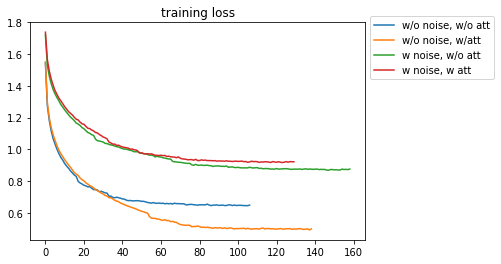

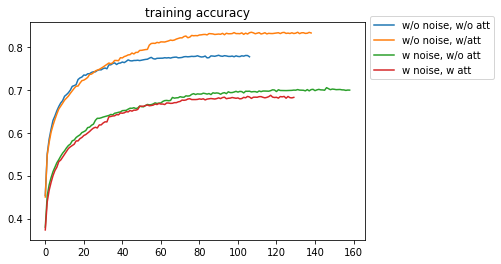

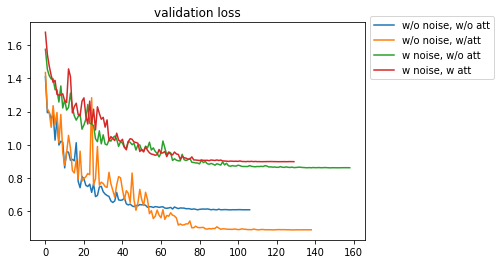

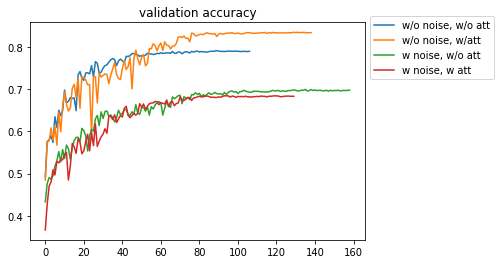

In [21]:
n_exp = len(Experiment_list)
Expname = ['w/o noise, w/o att', 'w/o noise, w/att', 'w noise, w/o att', 'w noise, w att']
for idx in np.arange(n_exp):
    plt.plot(np.arange(len(train_loss[idx])), train_loss[idx], label = Expname[idx])
plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1.05))
plt.title('training loss')
plt.show()
    
for idx in np.arange(n_exp):
    plt.plot(np.arange(len(train_acc[idx])), train_acc[idx], label = Expname[idx])
plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1.05))
plt.title('training accuracy')
plt.show()

for idx in np.arange(n_exp):
    plt.plot(np.arange(len(valid_loss[idx])), valid_loss[idx], label = Expname[idx])
plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1.05))
plt.title('validation loss')
plt.show()

for idx in np.arange(n_exp):
    plt.plot(np.arange(len(valid_acc[idx])), valid_acc[idx], label = Expname[idx])
plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1.05))
plt.title('validation accuracy')
plt.show()



In [ ]:
### Backup
## Simple case
K.clear_session()
use_att = False

X_train, X_test, y_train, y_test = get_data(add_noise=True)
model = build_model(use_att)
model.summary()

optim = Adam(lr=1e-4)
model.compile(loss = 'categorical_crossentropy', optimizer = optim, metrics=['accuracy'])

"""
model_history = model.fit(X_train, y_train, 
                          epochs=100,
                          batch_size=64,
                          validation_data=(X_test,y_test)
                          )
"""
model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=64), 
                                    workers = 6,
                                    epochs=100,
                                    validation_data=(X_test,y_test), 
                                    callbacks=[reduce_lr])


In [71]:
# MNIST: Test acc: 0.9975